<a href="https://colab.research.google.com/github/jefffang19/image_processing_final/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework requirement:
pytorch == 1.6.0

In [1]:
!python --version

Python 3.6.9


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 5.9MB 69.1MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [4]:
# if use google colab, mount your drive

from google.colab import drive
drive.mount('/content/gdrive')

dataset_path = F"/content/gdrive/My Drive/ip_final/data/train"

Mounted at /content/gdrive


# The structure of the dataset

```
0 (patient)
  |
  | -|- CT => mask
     |- FT => mask
     |- MN => mask
     |- T1 => input image 1
     |- T2 => input image 2
```



In [5]:
import cv2
import matplotlib.pyplot as plt
import os

# Define dataset

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import numpy as np

In [7]:
class Dataset(BaseDataset):
    """
    Args:
        path (str): path to dataset
        task (str): which task to do
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            path,
            task='CT', # CT, FT, MN
            augmentation=None, 
            preprocessing=None,
    ):
        self.patientId = sorted(os.listdir(path))
        self.num_imgs_of_each_pat = [] # count number of images for each patient
        self.ct = []
        self.ft = []
        self.mn = []
        self.t1 = []
        self.t2 = []

        # append file path
        for i in self.patientId:
          # append each class of images
          _cts = sorted(os.listdir('{}/{}/CT/'.format(path, i)))
          _cts = ['{}/{}/CT/{}'.format(path, i, j) for j in _cts]
          self.ct.append(_cts)
          _fts = sorted(os.listdir('{}/{}/FT/'.format(path, i)))
          _fts = ['{}/{}/FT/{}'.format(path, i, j) for j in _fts]
          self.ft.append(_fts)
          _mns = sorted(os.listdir('{}/{}/MN/'.format(path, i)))
          _mns = ['{}/{}/MN/{}'.format(path, i, j) for j in _mns]
          self.mn.append(_mns)
          _t1s = sorted(os.listdir('{}/{}/T1/'.format(path, i)))
          _t1s = ['{}/{}/T1/{}'.format(path, i, j) for j in _t1s]
          self.t1.append(_t1s)
          _t2s = sorted(os.listdir('{}/{}/T2/'.format(path, i)))
          _t2s = ['{}/{}/T2/{}'.format(path, i, j) for j in _t2s]
          self.t2.append(_t2s)

          # count number of images in each patient
          self.num_imgs_of_each_pat.append(len(_cts))

        # print(self.ct)
        # print(self.ft)
        # print(self.mn)
        # print(self.t1)
        # print(self.t2)


        # check if do augmentation and preprocess
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):

        # count number i in which patient
        i_img = i
        pat = 0
        for n, max_value in enumerate(self.num_imgs_of_each_pat):
          if i_img < max_value:
            break
          else:
            i_img -= max_value
            pat += 1
          
          # if i still bigger than the last images number, raise error
          if n == len(self.num_imgs_of_each_pat) - 1:
            raise 'Dataset index out of range !'

        # now we know we want to get
        # patient id: pat
        # image #: i_img
        
        # read img
        image_t1 = cv2.imread(self.t1[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # image = cv2.resize(image, (800, 640)) # image size of multiple of 2^network_depth ie. 32px
        image_t2 = cv2.imread(self.t2[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ct = cv2.imread(self.ct[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ft = cv2.imread(self.ft[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_mn = cv2.imread(self.mn[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (800, 640)) # iamge size of multiple of 2^network_depth ie. 32px

        # stack the images and masks
        image = np.stack((image_t1, image_t2), axis=2)
        mask = np.stack((mask_ct, mask_ft, mask_mn), axis=2)
        
        
        # apply augmentations
        if self.augmentation:
            # 3 channel needed to use augmentation
            # so we pad a channel for image
            _image = np.stack((image[...,0], image[...,1], np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)), axis=2)
            sample = self.augmentation(image=_image, mask=mask)
            _image, mask = sample['image'], sample['mask']

            # assign the first two channel back
            image = np.stack((_image[...,0], _image[...,1]), axis=2)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # normalize needs to be done or training evalutation will be wrong
        # normalize needs to do after augmentations, or will cause error
        image = image/255 # normalize image
        mask = mask/255 # normalize image
            
        return image, mask
        
    def __len__(self):
        return np.sum(self.num_imgs_of_each_pat)

In [8]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
train_set = Dataset(dataset_path)

In [10]:
# number of sets of imgs and labels (t1, t2, ct, ft, mn)
len(train_set)

189

In [11]:
image, mask = train_set[40]

print(image.shape, mask.shape)

(512, 512, 2) (512, 512, 3)


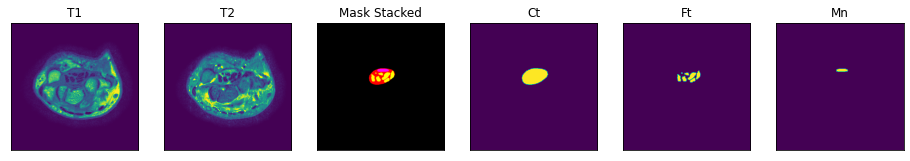

In [12]:
# visual data
visualize(
    t1=image[...,0],
    t2=image[...,1],
    mask_stacked=mask,
    ct=mask[...,0],
    ft=mask[...,1],
    mn=mask[...,2]
)

# preprocess & data augmentation

In [13]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 36.7MB 88kB/s 
     |████████████████████████████████| 952kB 49.3MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [14]:
import albumentations as albu

def get_training_augmentation():
    # TODO: keep augmentation suitable for medical image
    train_transform = [

      albu.HorizontalFlip(p=0.5),

      albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

      albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
      albu.RandomCrop(height=320, width=320, always_apply=True),

      albu.IAAAdditiveGaussianNoise(p=0.2),
      albu.IAAPerspective(p=0.5),

      albu.OneOf(
          [
              albu.CLAHE(p=1),
              albu.RandomBrightness(p=1),
              albu.RandomGamma(p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.IAASharpen(p=1),
              albu.Blur(blur_limit=3, p=1),
              albu.MotionBlur(blur_limit=3, p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.RandomContrast(p=1),
              albu.HueSaturationValue(p=1),
          ],
          p=0.9,
      ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_preprocessing_no_pretrain():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


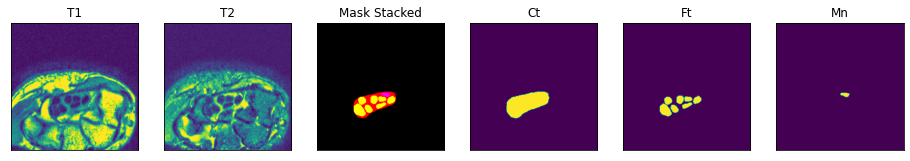

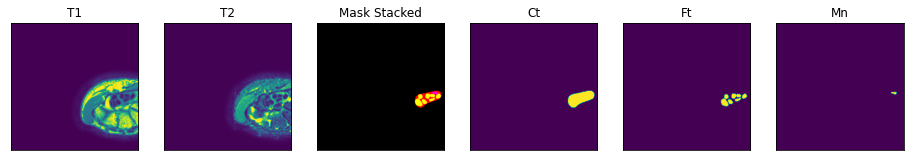

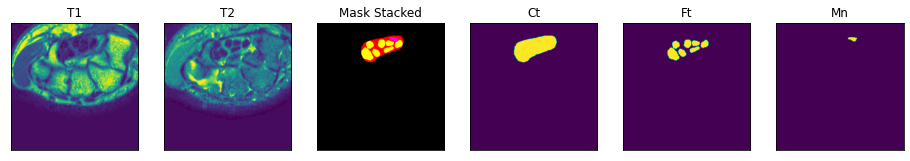

In [15]:
#### Visualize augmented images and masks

augmented_trainset = Dataset(
    dataset_path,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_trainset[60]
    # visual data
    visualize(
        t1=image[...,0],
        t2=image[...,1],
        mask_stacked=mask,
        ct=mask[...,0],
        ft=mask[...,1],
        mn=mask[...,2]
    )

# create model

In [16]:
# Download segmentation model pytorch
!pip install segmentation-models-pytorch

     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 245kB 27.4MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12420 sha256=58e5a20cd3e9c2f322e6fe44c577a5b4adfdfca4521c26320b3bf6ccffe4a3af
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=5431f68b8ab7fd04e30333694ca2015af9fc5ec19e9056961cded2430fac4074
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


U-Net++

docs:
https://smp.readthedocs.io/en/latest/models.html#id2

```
segmentation_models_pytorch.UnetPlusPlus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=1, activation=None, aux_params=None)
```



In [70]:
import segmentation_models_pytorch as smp
import torch

DEVICE = 'cpu'
if torch.cuda.is_available():
  print('using gpu')
  DEVICE = 'cuda'
else:
  print('using cpu')

# our input:
# t1, t2 stacked
# our output has 3 classes (ct, ft, mn)
# because our mask has overlay, so we should not use softmax at last layer activation
model = smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid')

using gpu


In [71]:
!pip install torchsummary

In [72]:
from torchsummary import summary

if torch.cuda.is_available():
  summary(model.cuda(), (2, 576, 576))
else:
  summary(model, (2, 576, 576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 288]           6,272
       BatchNorm2d-2         [-1, 64, 288, 288]             128
              ReLU-3         [-1, 64, 288, 288]               0
         MaxPool2d-4         [-1, 64, 144, 144]               0
            Conv2d-5         [-1, 64, 144, 144]          36,864
       BatchNorm2d-6         [-1, 64, 144, 144]             128
              ReLU-7         [-1, 64, 144, 144]               0
            Conv2d-8         [-1, 64, 144, 144]          36,864
       BatchNorm2d-9         [-1, 64, 144, 144]             128
             ReLU-10         [-1, 64, 144, 144]               0
       BasicBlock-11         [-1, 64, 144, 144]               0
           Conv2d-12         [-1, 64, 144, 144]          36,864
      BatchNorm2d-13         [-1, 64, 144, 144]             128
             ReLU-14         [-1, 64, 1

# 5 fold cross-validation is required

In [73]:
trainset = Dataset(
    dataset_path,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing_no_pretrain(),
)

In [74]:
def trainLoaders(*datasets, batch_size=8):
  loaders = []
  for i in datasets:
    loaders.append(torch.utils.data.DataLoader(i, batch_size=batch_size, shuffle=True, num_workers=12))
  
  return loaders

In [75]:
#split the training dataset into 5 fold
len_trainset_1_4 = len(trainset)//5
# the last fold
len_trainset_5 = len(trainset)%len_trainset_1_4 + len_trainset_1_4

training_sets = torch.utils.data.random_split(trainset, [len_trainset_1_4,len_trainset_1_4,len_trainset_1_4,len_trainset_1_4,len_trainset_5])
training_loaders = trainLoaders(*training_sets)

In [76]:
training_loaders

In [77]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [78]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [79]:
save_model_path = '/content/gdrive/My Drive/ip_final'

# Dice loss and Dice Score

https://zhuanlan.zhihu.com/p/86704421

## dice loss = 1 - dice score

In [85]:
five_fold_dice = {
    0: [], 1: [], 2: [], 3: [], 4: []
}

EPOCH = 1


In [86]:
#5-fold validation
#let the k-th trainloader be the validation
for k in range(5):
  print('\nfold #{} as valid'.format(k))
  for n_fold in range(5):
    print('\ntrain fold #{}'.format(n_fold))
    #do not train the validation data
    if(n_fold == k):
      print('fold #{} is validation, skip'.format(n_fold))
      continue
    
     # train model for N epochs
    max_score = 0

    for i in range(EPOCH):
        
        print('\nEpoch: {}'.format(i))

        train_logs = train_epoch.run(training_loaders[n_fold])
        valid_logs = valid_epoch.run(training_loaders[k])

        # save dice of each fold
        five_fold_dice[n_fold].append(1 - valid_logs['dice_loss'])

        # do something (save model, change lr, etc.)
        if max_score > dice_sum:
            max_score = dice_sum
            torch.save(model.state_dict(), save_model_path + '/fold{}_best_model.pth'.format(n_fold))
            print('Model saved!')
            
        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')


fold #0 as valid

train fold #0
fold #0 is validation, skip

train fold #1

Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s, dice_loss - 0.789, iou_score - 0.4991]

train fold #2

Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s, dice_loss - 0.7638, iou_score - 0.4916]

train fold #3

Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s, dice_loss - 0.7833, iou_score - 0.3837]

train fold #4

Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s, dice_loss - 0.7821, iou_score - 0.3534]

fold #1 as valid

train fold #0

Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s, dice_loss - 0.7776, iou_score - 0.2648]

train fold #1
fold #1 is validation, skip

train fold #2

Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s, dice_loss - 0.7335, iou_score - 0.4425]

train fold #3

Epoch: 0
valid: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s, dice_loss - 0.7907, iou_score - 0.4761]

train fold #4

Epoch: 0
valid: 100%|██████████| 5/5 

In [87]:
five_fold_dice

{0: [0.22239127159118655,
  0.23675029277801518,
  0.2079427480697632,
  0.3637792766094208],
 1: [0.21102970838546753,
  0.30165711641311643,
  0.3058249711990356,
  0.34240480264027906],
 2: [0.2361713409423828,
  0.26651369333267216,
  0.2952016592025757,
  0.3671836654345195],
 3: [0.21673356294631962,
  0.20926628112792967,
  0.3044362306594849,
  0.30533899863560987],
 4: [0.2178966879844666,
  0.2529185295104981,
  0.3081615924835205,
  0.32261297702789304]}

# test loader

In [ ]:
testset_path = F"/content/gdrive/My Drive/ip_final/data/test"

testset = Dataset(
    testset_path,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing_no_pretrain(),
)

In [122]:
test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)